<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/RNN_Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D,\
LSTM,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [8]:
!pip install -U scikit-learn

In [9]:
from sklearn.metrics import mean_absolute_percentage_error

In [10]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2023-11-23 10:49:07--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-11-23 10:49:07 ERROR 403: Forbidden.



In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/yeesem/Time-Series-Data-Analysis/main/airline_passengers.csv",index_col = 'Month',parse_dates = True)

In [12]:
df['LogPassengers'] = np.log(df['Passengers'])

In [13]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [14]:
#Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [15]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [16]:
#Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t : t + T]
  X.append(x)
  y = series[t + T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N = len(X)

print("X.shape: ",X.shape," Y shape: ",Y.shape)

X.shape:  (133, 10, 1)  Y shape:  (133,)


In [17]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [18]:
#RNN
i = Input(shape = (T,1))
x = LSTM(24)(i)
x = Dense(1)(x)

model = Model(i,x)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2521 (9.85 KB)
Trainable params: 2521 (9.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


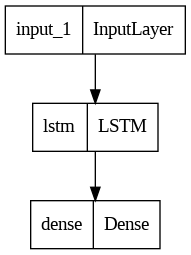

In [20]:
tf.keras.utils.plot_model(model)

In [21]:
r = model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [22]:
r = model.fit(
    XTrain,
    YTrain,
    epochs = 100,
    validation_data = (XTest,YTest)
)

Epoch 1/100
4/4 [==============================] - 9s 282ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 2/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 3/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 4/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 5/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 6/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 7/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 8/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 9/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 10/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 11/100
4/4 [

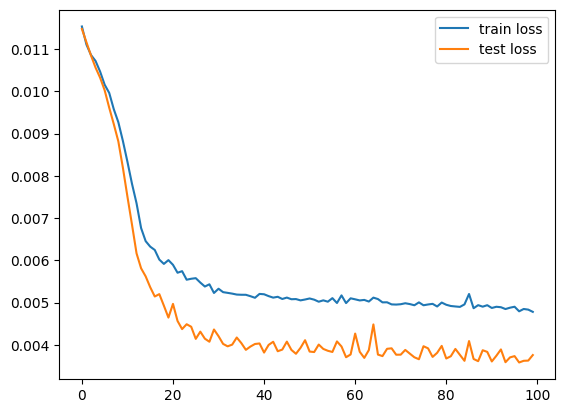

In [23]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [24]:
#First T+1 values are not predictable
train_idx[:T+1] = False

In [25]:
PTrain = model.predict(XTrain).flatten()
PTest = model.predict(XTest).flatten()

1/1 [==============================] - 0s 71ms/step


In [26]:
#Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [27]:
#Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [28]:
#1-step forecast
df.loc[train_idx,'1step_train'] = prev[train_idx] + PTrain
df.loc[test_idx,'1step_test'] = prev[test_idx] + PTest

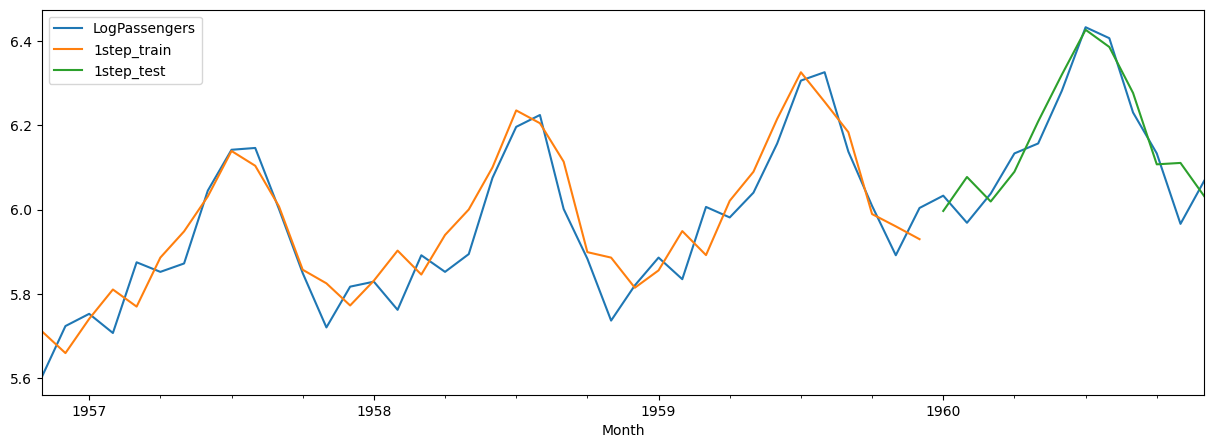

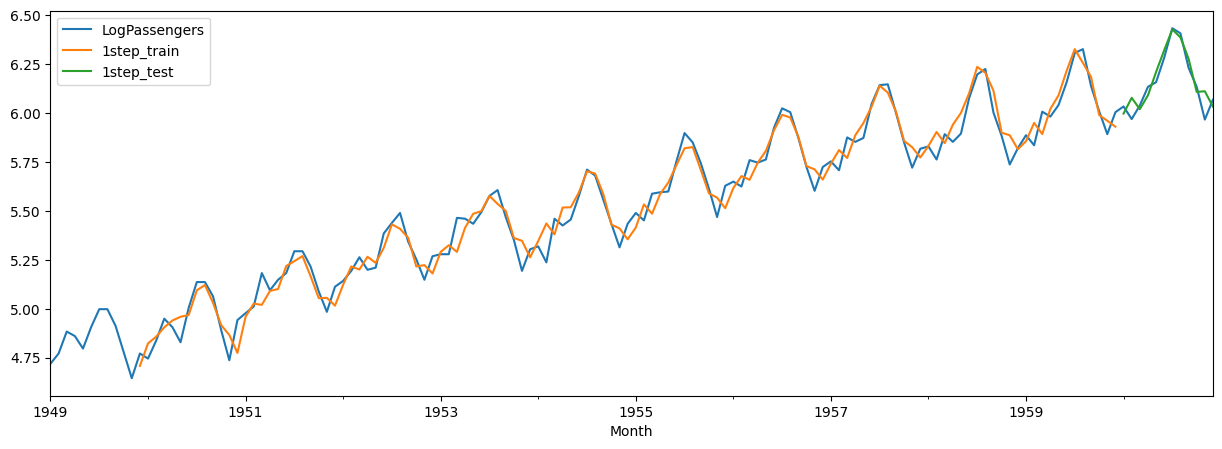

In [29]:
#plot 1-step forecast
cols = [
    'LogPassengers',
    '1step_train',
    '1step_test'
]

df.iloc[-50:][cols].plot(figsize = (15,5))
df[cols].plot(figsize = (15,5));

In [30]:
#multi step predictions
multistep_predictions = []

#first test input
x_last = XTest[0]

for t in range(len(multistep_predictions) < NTest):
    p = model.predict(x_last.reshape(1,-1,1))[0]

    #Update the predictions list
    multistep_predictions.append(p)

    #Update the new input
    x_last = XTest[0] = np.roll(x_last,-1)
    x_last[-1] = p

1/1 [==============================] - 0s 52ms/step


In [31]:
df.loc[test_idx,'multistep'] = last_train + np.cumsum(multistep_predictions)

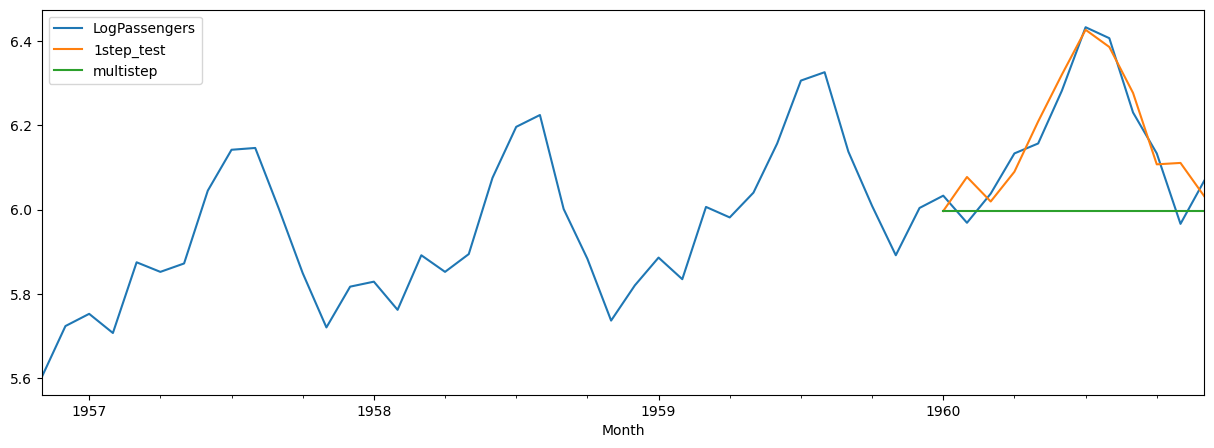

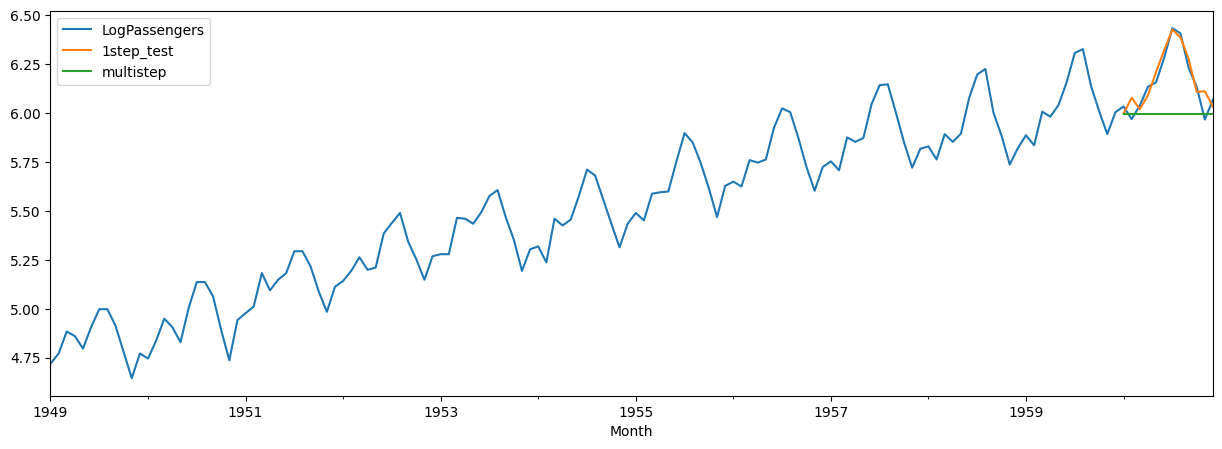

In [32]:
cols = [
    'LogPassengers',
    '1step_test',
    'multistep'
]
df.iloc[-50:][cols].plot(figsize = (15,5))
df[cols].plot(figsize = (15,5));

In [33]:
#Make the multi-output supervised dataset
Tx = T
Ty = NTest
X = []
Y = []

for t in range(len(series) - Tx - Ty):
  x = series[t : t + Tx]
  X.append(x)
  y = series[t + Tx : t + Tx + Ty]
  Y.append(y)

X = np.array(X).reshape(-1,Tx,1)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)

print("X shape: ",X.shape, " Y shape: ",Y.shape)

X shape:  (121, 10, 1)  Y shape:  (121, 12)


In [34]:
XTrain_m,YTrain_m = X[:-1],Y[:-1]
XTest_m,YTest_m = X[-1:],Y[-1:]

In [35]:
#RNN
i = Input(shape = (Tx,1))
x = LSTM(24,return_sequences = True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)

model = Model(i,x)

In [36]:
check_point = ModelCheckpoint(
    'best_model',monitor = 'val_loss',save_best_model = True
)

In [37]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [38]:
r = model.fit(
    XTrain_m,
    YTrain_m,
    epochs = 300,
    validation_data = (XTest_m,YTest_m),
    callbacks = [check_point]
)

Epoch 1/300
4/4 [==============================] - 7s 2s/step - loss: 0.0115 - val_loss: 0.0116
Epoch 2/300
4/4 [==============================] - 3s 938ms/step - loss: 0.0114 - val_loss: 0.0118
Epoch 3/300
4/4 [==============================] - 3s 930ms/step - loss: 0.0113 - val_loss: 0.0119
Epoch 4/300
4/4 [==============================] - 3s 943ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 5/300
4/4 [==============================] - 4s 1s/step - loss: 0.0112 - val_loss: 0.0115
Epoch 6/300
4/4 [==============================] - 3s 1s/step - loss: 0.0111 - val_loss: 0.0114
Epoch 7/300
4/4 [==============================] - 3s 906ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 8/300
4/4 [==============================] - 3s 1s/step - loss: 0.0110 - val_loss: 0.0114
Epoch 9/300
4/4 [==============================] - 3s 1s/step - loss: 0.0110 - val_loss: 0.0114
Epoch 10/300
4/4 [==============================] - 4s 1s/step - loss: 0.0109 - val_loss: 0.0113
Epoch 11/300
4/4 [=========

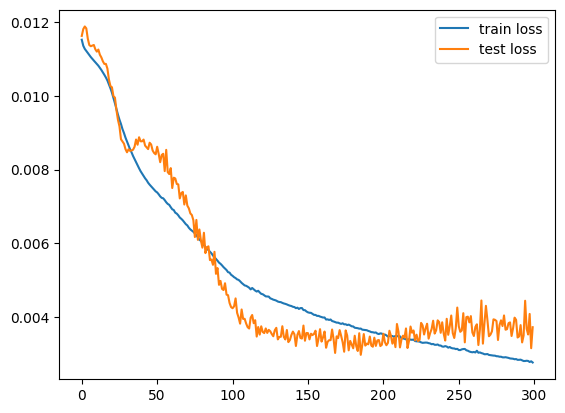

In [39]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [40]:
#Load best model
best_model = tf.keras.models.load_model('best_model')

In [41]:
PTrain = best_model.predict(XTrain_m)
PTest = best_model.predict(XTest_m)

1/1 [==============================] - 0s 17ms/step


In [42]:
PTrain.shape,PTest.shape

((120, 12), (1, 12))

In [43]:
#Make sure the data is in the right shape
PTrain = PTrain[:,0]
PTest = PTest[0]

In [44]:
#Save multi-output forecast
df.loc[test_idx,'multioutput'] = last_train + \
np.cumsum(PTest)

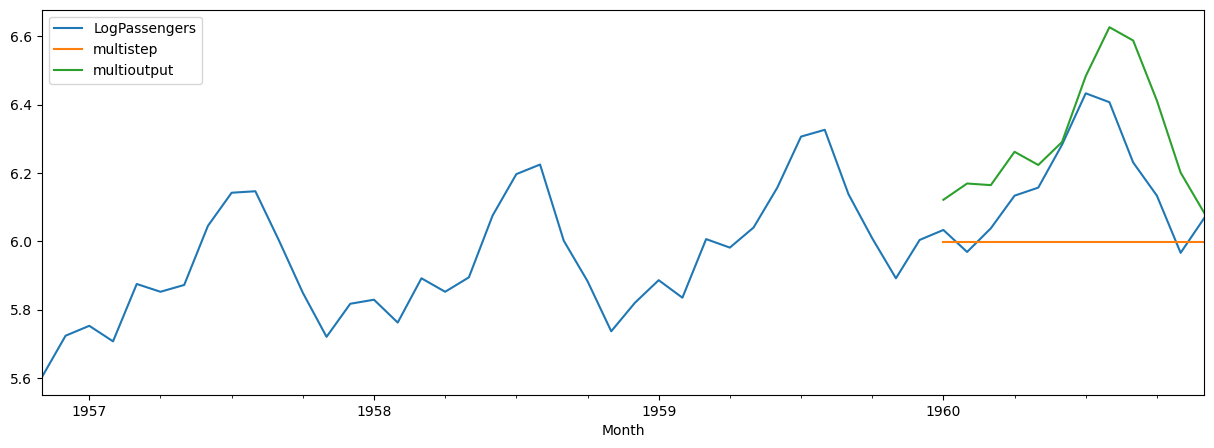

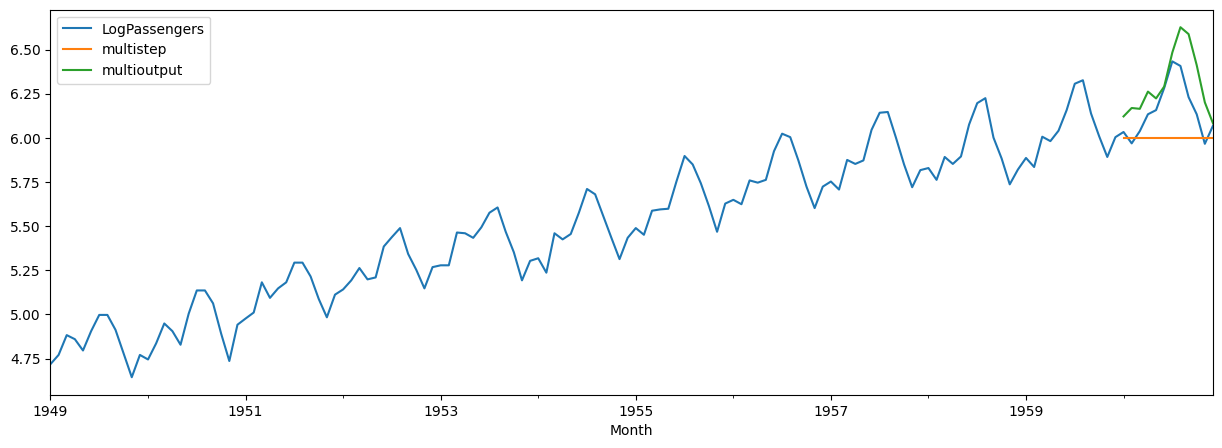

In [46]:
#Plot all forecast
cols = [
    'LogPassengers',
    'multistep',
    'multioutput',
    '1step_test'
]
df.iloc[-50:][cols].plot(figsize = (15,5))
df[cols].plot(figsize = (15,5));